In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state,get_dropbox_folders
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value
)
from matplotlib import cm
from matplotlib.patches import Rectangle
from amftrack.transport.align_video_network import identify_nodes, selected_rectangle

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plates = [
# "3_20220426",
# "12_20220502",
# "13_20220422",
# "16_20220419",
# "21_20220502",
# "480_20221205",
# "28_20230227",
# "206_20230303",
# "202_20230314",
# "218_20230227",
# "219_20230307",
"229_20230330",
# "240_20230328"
]

In [3]:
plates = ["910_202305016"]

In [4]:
# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/3837 [00:00<?, ?it/s]

In [5]:
folders = all_folders.loc[all_folders['unique_id']=='910_202305016']
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]

In [6]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 5
exp.load(folders.iloc[i:i+2],suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-17 00:29:00
2023-05-17 02:29:00


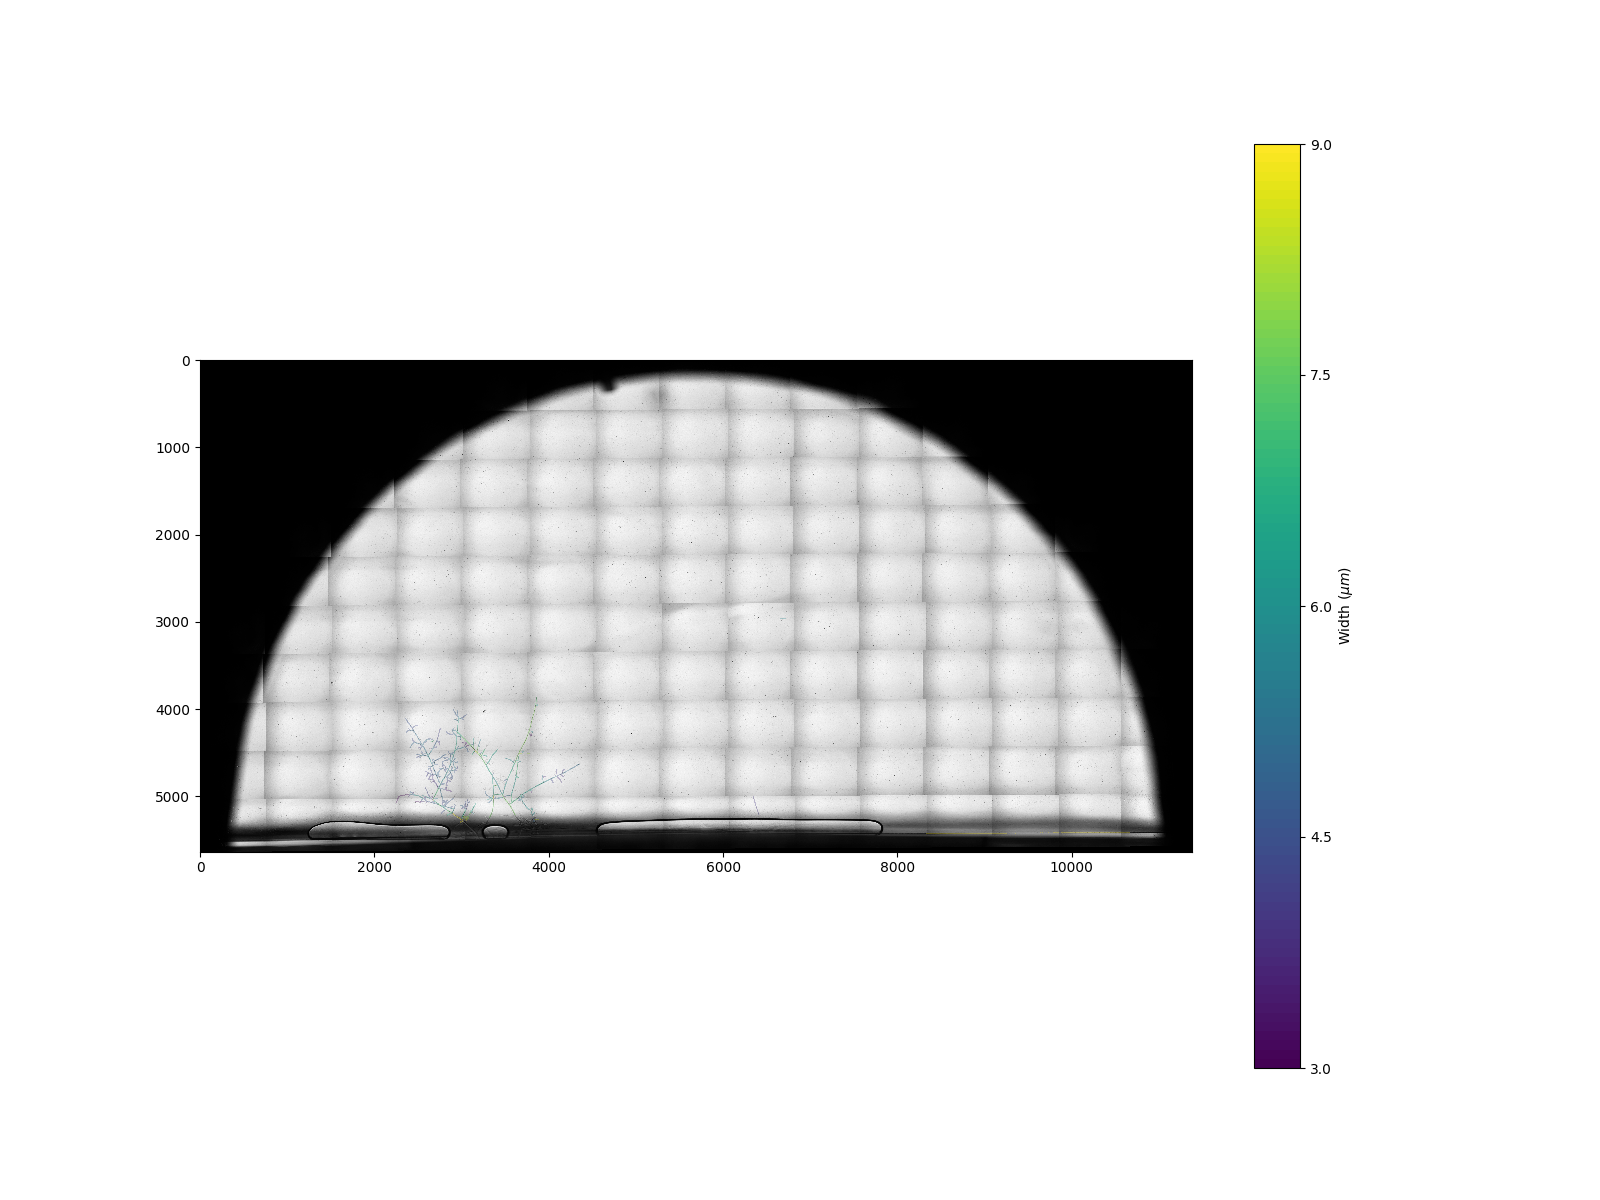

Text(value='', description='Point name:', placeholder='Type point name here')

ValueError: not enough values to unpack (expected 3, got 2)

In [7]:
cid, fig, dicopoint = identify_nodes(exp,t)

In [11]:
dicopoint

{'1': array([4461. , 2072.8]), '3': array([2602. , 3457.4])}

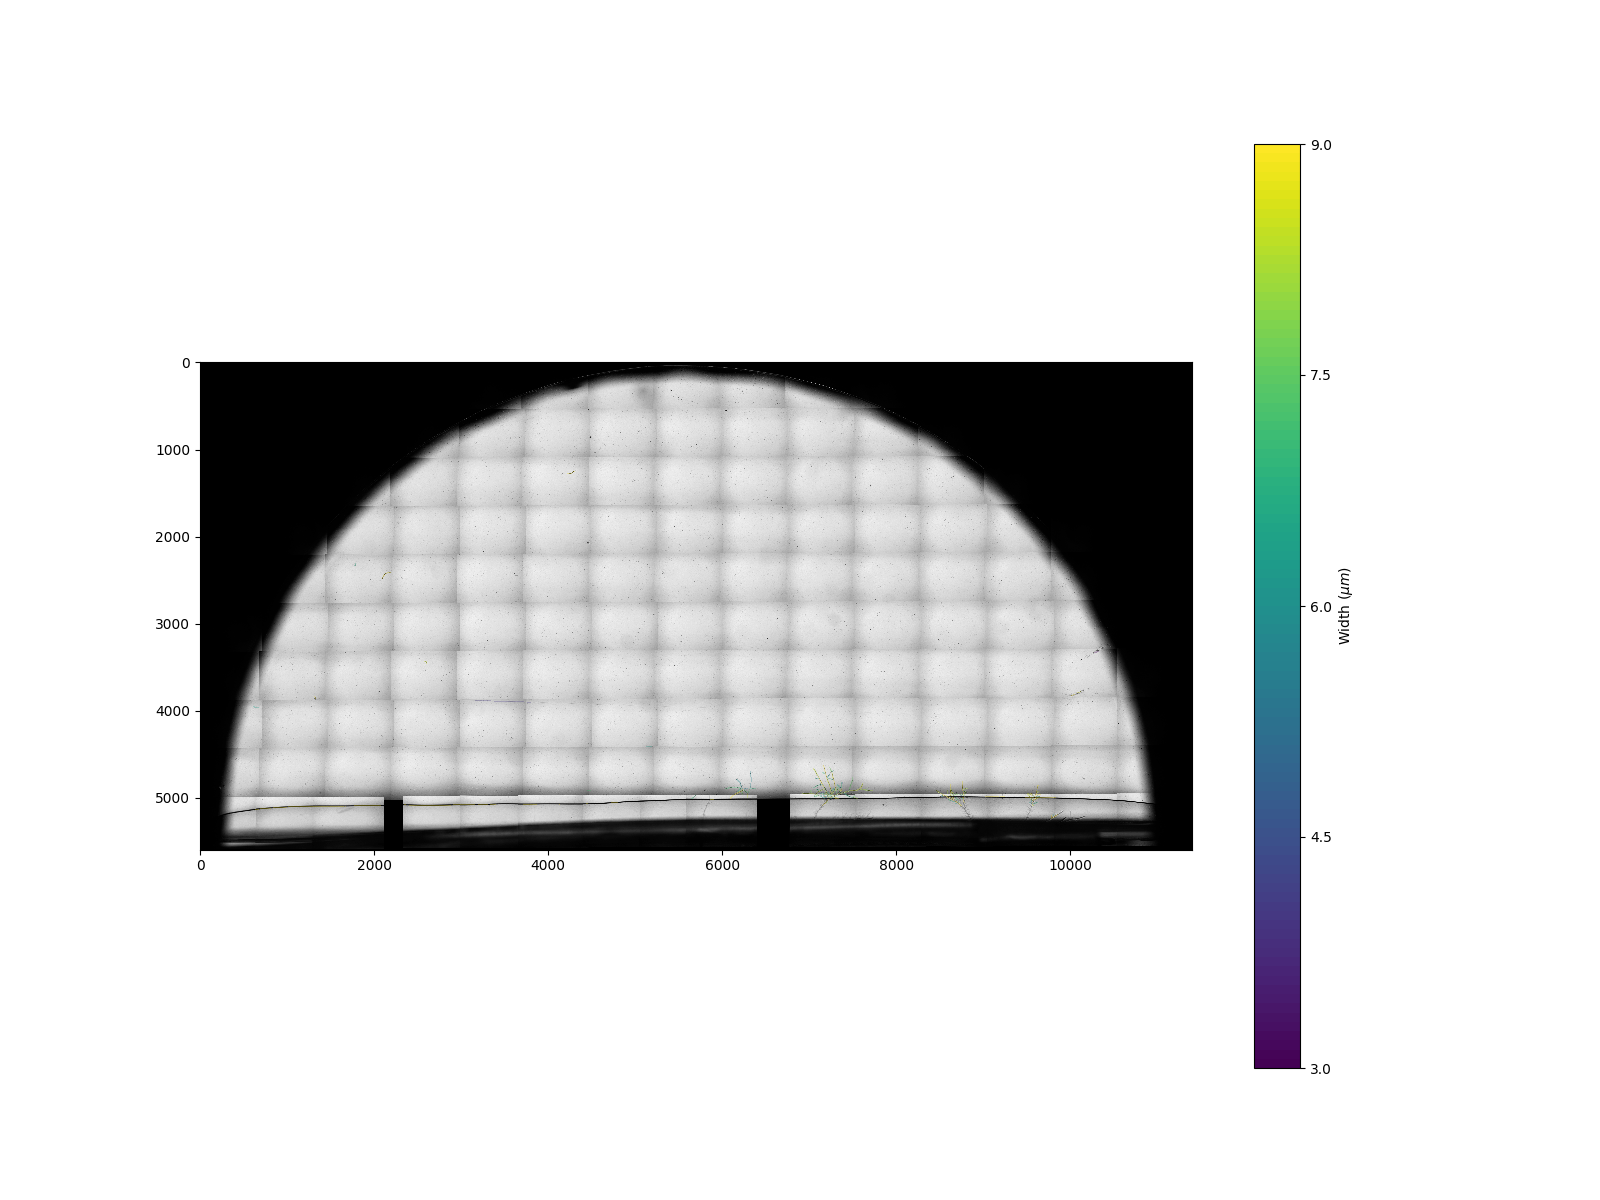

Text(value='', description='Point name:', placeholder='Type point name here')

In [10]:
vmax = 9
vmin = 3
region = None
nodes = get_all_nodes(exp,t)
downsizing = 5

fig,ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: edge.width(t),
    region = region,
    # nodes = nodes,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=True,
    dilation=10,
    figsize=(16, 12),
    alpha = 0.3,
    downsizing = downsizing
    
)
# fig,ax = plt.subplots()
points = np.transpose([(node.pos(t)[1]/downsizing,node.pos(t)[0]/downsizing) for node in nodes])

scatter_plot = ax.scatter(points[0],points[1],s=5)

# Variable to store the selected point information
selected_point_info = {}

# Create a text box for input
text_box = widgets.Text(
    value='',
    placeholder='Type point name here',
    description='Point name:',
    disabled=False
)
display(text_box)
dicopoint = {}
selected_rectangle = None

def on_text_box_submit(sender):
    selected_point_info[text_box.value] = selected_point
    print(f'Saved point {text_box.value} with coordinates {selected_point}')
    dicopoint[text_box.value] = selected_point
    text_box.value = ''  # clear the text box

text_box.on_submit(on_text_box_submit)

def onclick(event):
    global selected_point, selected_rectangle
    distances = (points[0]-event.xdata)**2 + (points[1]-event.ydata)**2
    closest_point_index = np.argmin(distances)
    selected_point = points[:,closest_point_index]
    print(f"You clicked closest to point at coordinates ({selected_point[0]}, {selected_point[1]})")
    
    # Draw a rectangle around the selected point, and remove the previous one
    if selected_rectangle is not None:
        selected_rectangle.remove()
    selected_rectangle = Rectangle((selected_point[0]-2.5, selected_point[1]-2.5), 5, 5, fill=False, color='red')
    ax.add_patch(selected_rectangle)
    fig.canvas.draw()

# Connect the click event with the callback function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
# Plot points as individual scatter plots and store in a list


Text(value='', description='Point name:', placeholder='Type point name here')

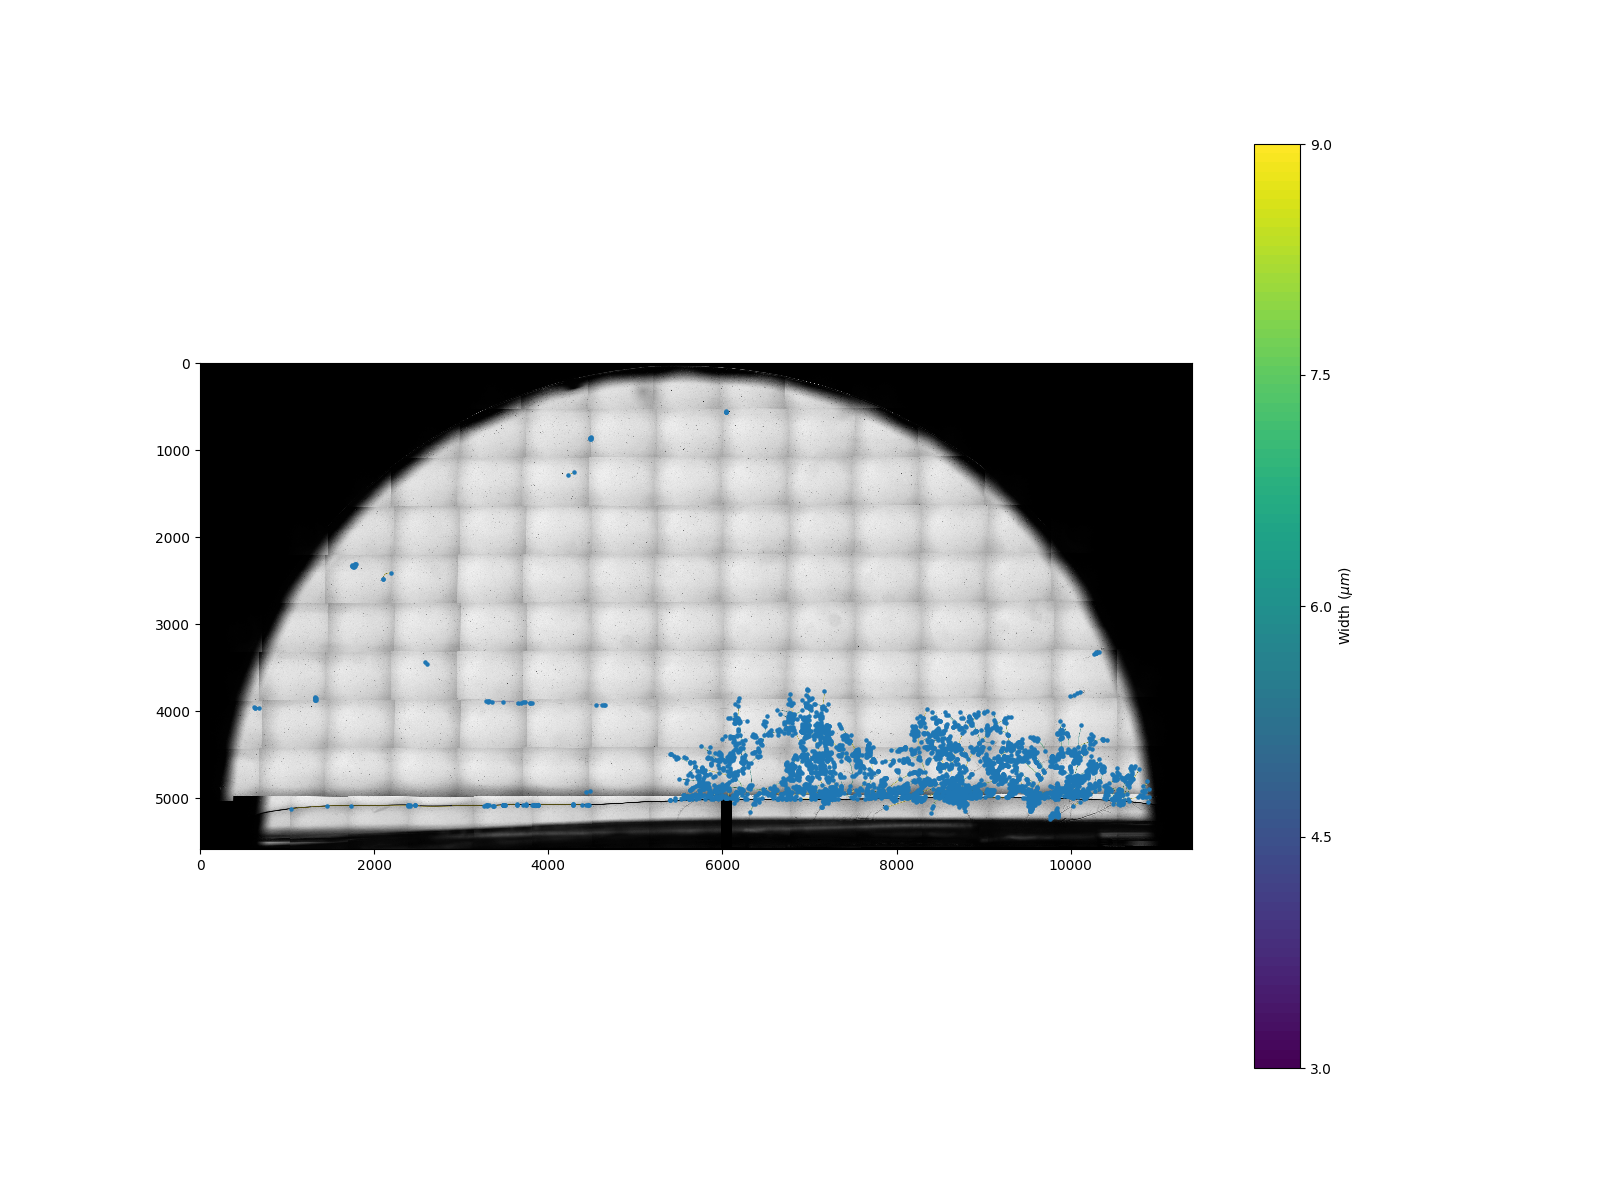

In [60]:
# fig,ax = plt.subplots()
# points = np.transpose([(node.pos(t)[1]/downsizing,node.pos(t)[0]/downsizing) for node in nodes])

scatter_plot = ax.scatter(points[0],points[1],s=5)

# Variable to store the selected point information
selected_point_info = {}

# Create a text box for input
text_box = widgets.Text(
    value='',
    placeholder='Type point name here',
    description='Point name:',
    disabled=False
)
display(text_box)
dicopoint = {}
def on_text_box_submit(sender):
    selected_point_info[text_box.value] = selected_point
    print(f'Saved point {text_box.value} with coordinates {selected_point}')
    dicopoint[text_box.value] = selected_point
    text_box.value = ''  # clear the text box

text_box.on_submit(on_text_box_submit)

def onclick(event):
    global selected_point, selected_rectangle
    distances = (points[0]-event.xdata)**2 + (points[1]-event.ydata)**2
    closest_point_index = np.argmin(distances)
    selected_point = points[:,closest_point_index]
    print(f"You clicked closest to point at coordinates ({selected_point[0]}, {selected_point[1]})")
    
    # Draw a rectangle around the selected point, and remove the previous one
    if selected_rectangle is not None:
        selected_rectangle.remove()
    selected_rectangle = Rectangle((selected_point[0]-2.5, selected_point[1]-2.5), 5, 5, fill=False, color='red')
    ax.add_patch(selected_rectangle)
    fig.canvas.draw()

# Connect the click event with the callback function
cid = fig.canvas.mpl_connect('button_press_event', onclick)



Text(value='', description='Point name:', placeholder='Type point name here')

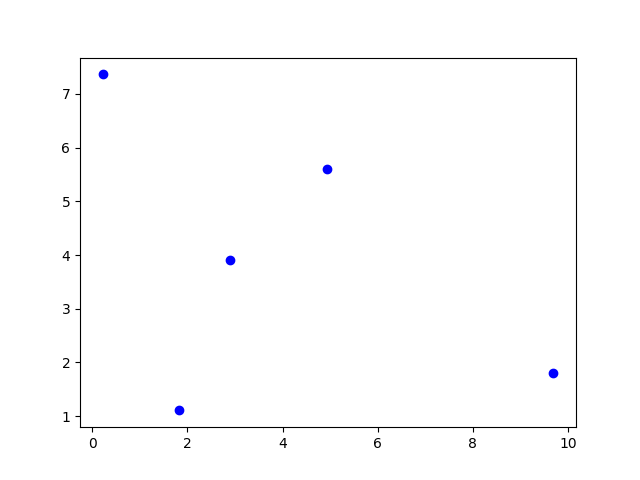

In [44]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Load an image
# img = plt.imread("test.png")

fig, ax = plt.subplots()
# im = ax.imshow(img, extent=(0, 10, 0, 10))  # You might need to adjust the extent depending on your image and points

# Create some points
points = np.random.rand(5, 2) * 10  # 5 random points. Change as needed.

# Plot points as individual scatter plots and store in a list
scatter_plots = [ax.scatter(x, y,color="blue") for x, y in points]

# Variable to store the selected point information
selected_point_info = {}

# Create a text box for input
text_box = widgets.Text(
    value='',
    placeholder='Type point name here',
    description='Point name:',
    disabled=False
)
display(text_box)
dicopoint = {}
def on_text_box_submit(sender):
    selected_point_info[text_box.value] = selected_point
    print(f'Saved point {text_box.value} with coordinates {selected_point}')
    dicopoint[text_box.value] = selected_point
    text_box.value = ''  # clear the text box

text_box.on_submit(on_text_box_submit)
def onclick(event):
    global selected_point, selected_rectangle
    distances = [(point[0]-event.xdata)**2 + (point[1]-event.ydata)**2 for point in points]
    closest_point_index = np.argmin(distances)
    selected_point = points[closest_point_index]
    print(f"You clicked closest to point at coordinates ({selected_point[0]}, {selected_point[1]})")
    
    # Change the color of the selected point
    colors[closest_point_index] = 'red'
    scatter_plot.set_facecolor(colors)
    
    # If there is a rectangle from a previous selection, remove it
    if selected_rectangle is not None:
        selected_rectangle.remove()
    
    # Create a new rectangle and add it to the plot
    selected_rectangle = patches.Rectangle((selected_point[0]-0.5, selected_point[1]-0.5), 2, 2, 
                                        linewidth=2, edgecolor='red', facecolor='none')
    fig.canvas.draw()


# Connect the click event with the callback function
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()
